In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import shap
import time
import seaborn

import sys
sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import FunctionCollection as fc
fc = importlib.reload(fc)
import os
import sqlite3
import torch
import captum.attr as c
from tqdm import tqdm

In [2]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'OscNext_Angle_m27'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 2,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': '23ge',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'output_offset': [3.14,1.57],
        'lr': 0.0209,
        'filename': 'dev_lvl7_mu_nu_e_classification_v003_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith, energy_log10',
        'TrTV': (0,1,1)
       }

In [3]:
filepath = os.path.join(path,'raw_data')

centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'width': [4.5],
                        'rqe': [1.175]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300],
                        'width': [3.5],
                        'rqe': [0.175]})

centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
                               x_transform = x_transform,
                               y_transform = y_transform,
                               shuffle = False)

In [146]:
device = torch.device('cuda')

import Model_Loaders.Model_27 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
model.eval();
model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [5]:
test = dataset[5192].to(device)
test2 = dataset[5193].to(device)

N_background = 5000
background = dataset.collate(dataset[np.random.choice(dataset.__len__(),N_background).tolist()]).to(device)

In [8]:
background.x.min(0)

torch.return_types.min(
values=tensor([-1.0000, -1.0000,  0.2147, -0.9607, -1.7554, -1.7369, -1.7094],
       device='cuda:0', dtype=torch.float64),
indices=tensor([    0,     0,  4289, 17859, 41463, 26325, 21857], device='cuda:0'))

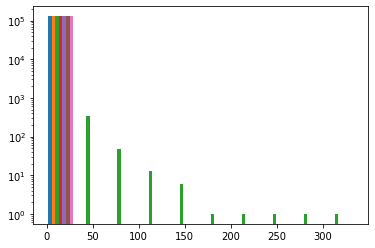

In [9]:
fig, ax = plt.subplots()
ax.hist(background.x.cpu().numpy());
ax.set_yscale('log')

In [34]:
# explainer = c.DeepLiftShap(model)
# explainer = c.FeatureAblation(model)
explainer = c.IntegratedGradients(model,multiply_by_inputs=False)

In [35]:
att = explainer.attribute(test.x,baselines=background.x.min(0)[0].unsqueeze(0)*5,target=0)
att1 = explainer.attribute(test.x,target=0)
att2 = explainer.attribute(test.x,baselines=torch.ones((1,7),device=device)*(-1000),target=0)

In [149]:
shap_explainer = c.ShapleyValueSampling(model)
N_perturb = 1024*8
true_shapvals = shap_explainer.attribute(test.x.unsqueeze(0),target=0,n_samples = 1000, perturbations_per_eval=N_perturb).squeeze().cpu()

In [95]:
# sample = torch.cat([test2.x[np.random.choice(test.x.shape[0]).tolist]]), 
# test2.x[np.random.choice(test.x.shape[0],9)]
# test2.x[np.random.choice(test.x.shape[0],test.x.shape[0],replace=False).tolist()]
sample = torch.cat([background.x[np.random.choice(test.x.shape[0],test.x.shape[0],replace=False).tolist()].unsqueeze(0) for j in range(1000)],dim=0)

In [103]:
ids, counts = background.batch.unique(return_counts=True)
sample = torch.cat([background.x[background.batch == i].unsqueeze(0) for i in ids[(counts == 15)]],dim=0)

In [112]:
sample.shape[0]

8370

In [131]:
deep_explainer = c.DeepLiftShap(model, multiply_by_inputs=True)
deep_shapvals = deep_explainer.attribute(test.x.unsqueeze(0),baselines=sample,target=0,return_convergence_delta=True)

torch.Size([8370, 7])
torch.Size([4185, 7])
torch.Size([4185, 7])


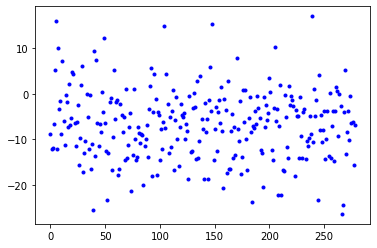

In [138]:
plt.figure()
plt.plot(deep_shapvals[1].cpu(),'b.')

In [113]:
e = shap.DeepExplainer(model, [t for t in sample])
shap_values = e.shap_values([test.x]);

torch.Size([4185, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])
torch.Size([30, 7])


torch.Size([30, 7])
torch.Size([30, 7])


In [29]:
def plot_shapvals(shapvals):
    fig, ax = plt.subplots(figsize=(10,2))
    im = ax.pcolor(shapvals.T,cmap='plasma')
    fig.colorbar(im)
    fig.tight_layout()

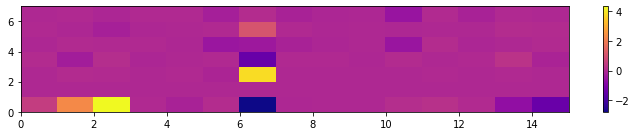

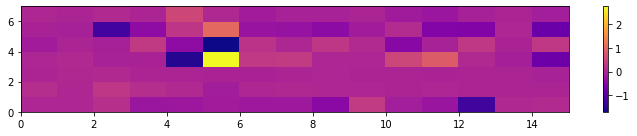

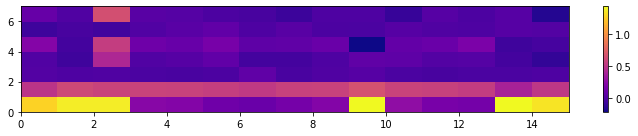

In [150]:
plot_shapvals(shap_values[0][0])
plot_shapvals(deep_shapvals[0].detach().cpu().squeeze())
plot_shapvals(true_shapvals)

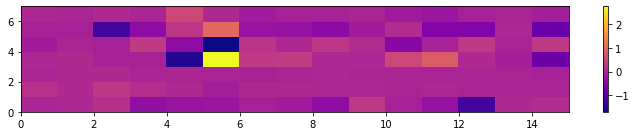

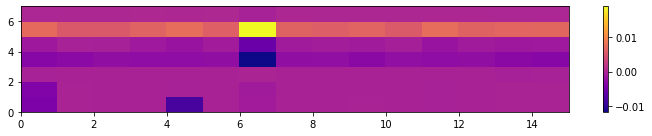

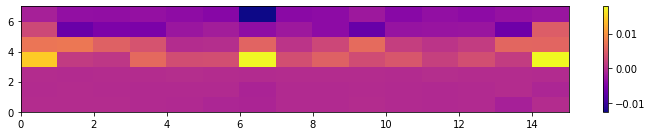

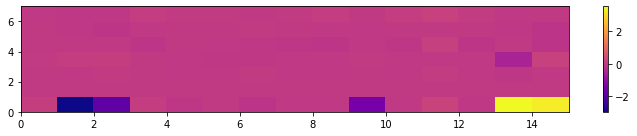

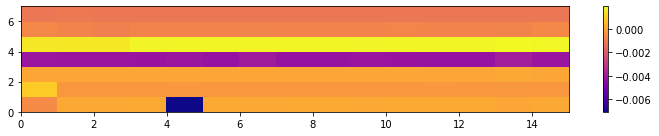

In [78]:
plot_shapvals(deep_shapvals.detach().cpu().squeeze())
plot_shapvals(att.cpu())
plot_shapvals(att1.cpu())
plot_shapvals(shap_values[1][0])
plot_shapvals(att2.cpu())

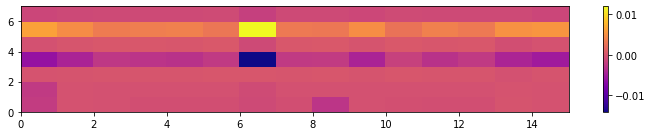

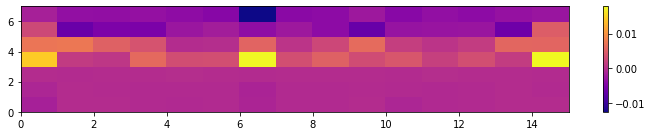

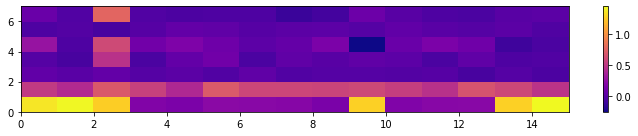

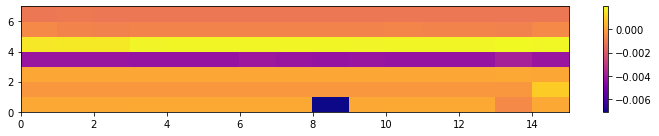

In [46]:
def plot_shapvals(shapvals):
    fig, ax = plt.subplots(figsize=(10,2))
    im = ax.pcolor(shapvals.T,cmap='plasma')
    fig.colorbar(im)
    fig.tight_layout()

plot_shapvals(att.cpu())
plot_shapvals(att1.cpu())
plot_shapvals(true_shapvals)
plot_shapvals(att2.cpu())

In [82]:
tmp[0].x.requires_grad

False

In [172]:
explainer = c.Saliency(model)
def create_sample(N,batch_size=3,N_features=args['N_dom_feats'],N_targets=args['N_outputs']):
    event_ids = np.random.choice(dataset.__len__(),N).tolist()
    loader = torch.utils.data.DataLoader(dataset[event_ids],
                                         batch_size=batch_size,
                                         collate_fn = lambda x: tuple(item.x.to(device) for item in x))
    
#     results = torch.zeros((N,N_features,N_targets))
    results = []
    for sample in tqdm(loader):
        tmp = [torch.cat([item for item in sample],0).unsqueeze(1)]
        for i in range(N_targets):
            att = explainer.attribute(sample,i)
#             tmp.append(torch.cat([item.sum(0).unsqueeze(0) for item in att],0).unsqueeze(1))
            tmp.append(torch.cat([item for item in att],0).unsqueeze(1))
        results.append(torch.cat(tmp,1))
    return torch.cat(results,dim=0)

sample = create_sample(7)
# explainer.attribute(tuple(item.x.to(device) for item in sample),0)

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 12.13it/s]


In [183]:
(sample[:,2]/sample[:,0]).mean(0).shape

torch.Size([7])

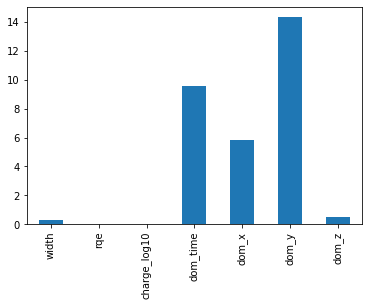

In [189]:
sample.shape
df_sample = pd.DataFrame((sample[:,1]/sample[:,0]).cpu().numpy(),columns=args['features'].split(', '))
plt.figure()
df_sample.abs().mean(0).plot.bar()

In [174]:
i = 0
(sample[:,i]/sample[:,i].sum(1).unsqueeze(1)).mean(0)

tensor([-0.1338, -0.1510,  1.4428,  0.0046,  0.0438,  0.0125, -0.2190],
       device='cuda:0', dtype=torch.float64)

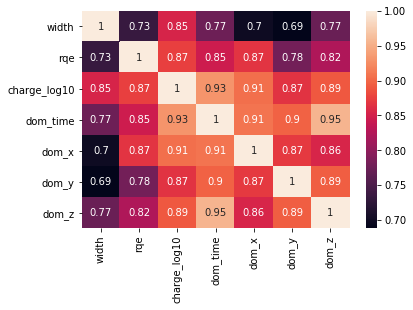

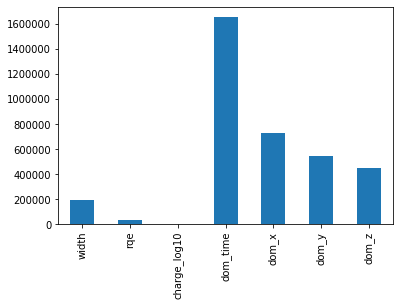

In [159]:
df = pd.DataFrame(sample[:,0].cpu().numpy(),columns=args['features'].split(', '))

seaborn.heatmap(df.corr(),annot=True)

plt.figure()
df.sum(0).plot.bar()

# fig, ax = plt.subplots()
# im = ax.matshow(df.corr())
# fig.colorbar(im)

In [105]:
torch.zeros((2,1)).unsqueeze(1).shape

torch.Size([2, 1, 1])

In [153]:
true_shapvals.shape, test.x.shape

(torch.Size([15, 7]), torch.Size([15, 7]))

(tensor([[1.4721, 1.5340, 0.7053]], device='cuda:0', dtype=torch.float64),
 tensor([0.8423, 2.1867, 1.4156], device='cuda:0', grad_fn=<RemainderBackward0>))

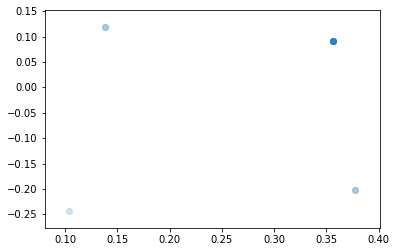

In [166]:
fig, ax = plt.subplots()

ax.scatter(test.x[:,-3].cpu(),test.x[:,-2].cpu(),alpha=0.2)
test.y, (model(test.x)[0]+args['output_offset'][0])%(2*np.pi)

In [364]:
import time
global_row = None
curr_time = time.time()
def onclick(event):
    global curr_time
    global global_row
    row = int(event.xdata + 0.5)
    global_row = row
#     ax.set_title(row)
    if time.time() - curr_time > 0.1:
        curr_time = time.time()
        ax.set_title(time.time())
        index_line.set_xdata([row,row])
        fig.canvas.draw()
        try:
            selected.set_data(tmp[row,-3],tmp[row,-2])
            selected.set_3d_properties(tmp[row,-1])
            fig2.canvas.draw()
        except:
            pass

tensor([[ 8.5194e-03,  1.3965e-01, -9.7565e-04,  1.8368e-02, -1.4618e-01,
         -3.4178e-02,  2.5522e-02],
        [ 1.2759e-02,  2.9757e-02,  4.4980e-02,  6.8832e-02, -2.7213e-03,
         -7.8157e-02,  1.1976e-06],
        [ 1.6478e-01,  2.6485e-01,  5.7101e-02, -4.9795e-02, -7.3886e-02,
         -1.2343e+00,  5.5004e-02],
        [-2.3629e-01,  1.2752e-01,  8.3375e-06, -3.7772e-02,  3.3057e-01,
         -3.9216e-01, -9.3538e-03],
        [-2.1594e-01,  6.3255e-02, -1.1346e-02, -1.5314e+00, -3.8041e-01,
          2.4910e-01,  5.2485e-01],
        [-1.4130e-01, -1.2371e-01, -1.8871e-02,  2.7474e+00, -1.6999e+00,
          1.0265e+00,  4.7912e-02],
        [-1.9752e-01,  3.7243e-02, -3.6655e-02,  3.0817e-01,  2.1595e-01,
         -2.6492e-01, -1.5319e-01],
        [-2.0407e-01,  3.8595e-02,  5.5480e-04,  3.3423e-01,  2.1485e-02,
         -2.7815e-01, -6.2699e-02],
        [-4.3774e-01,  2.1016e-02,  3.1581e-03,  7.6568e-03,  2.7435e-01,
         -4.0860e-01, -5.2786e-02],
        [ 

<IPython.core.display.Javascript object>


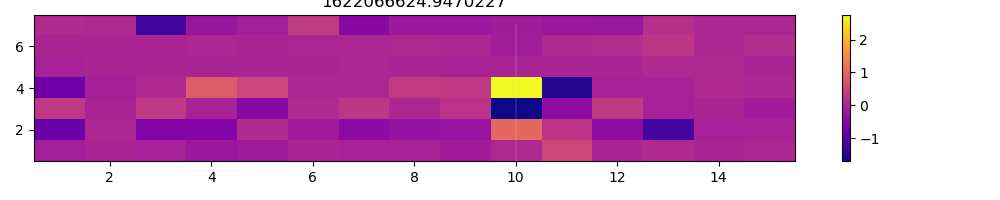

<IPython.core.display.Javascript object>


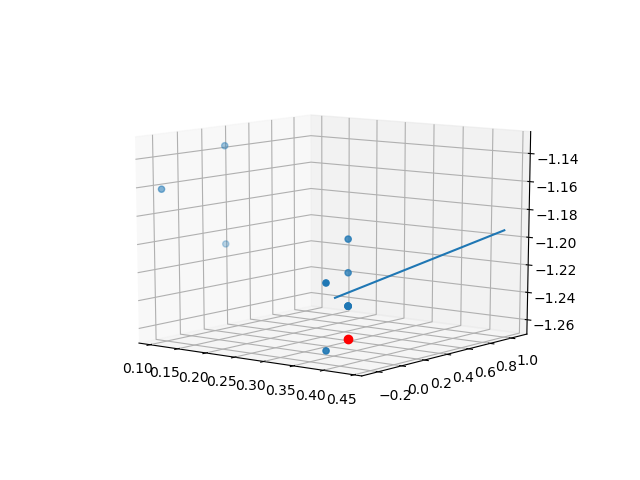

In [377]:
fig, ax = plt.subplots(figsize=(10,2))
# ax.imshow(shap_values[0][0].T)
im = ax.pcolor(*np.mgrid[15.5:-0.5:-1,7.5:-0.5:-1],deep_shapvals[0].squeeze().detach().cpu(),cmap='plasma')
index_line, = ax.plot([5,5],[0.5,7],'w',alpha=0.1)
fig.colorbar(im)
fig.tight_layout()
# fig.canvas.mpl_connect('motion_notify_event',onclick)
fig.canvas.mpl_connect('button_press_event',onclick)

tmp = test.x.cpu().clone()

CoC = (tmp[:,-3:]*tmp[:,-5].unsqueeze(1)).sum(0)/tmp[:,-5].sum()

def angle_to_vec(az,ze):
    x = np.sin(ze)*np.cos(az)
    y = np.sin(ze)*np.sin(az)
    z = np.cos(ze)
    return np.array([[0,x],[0,y],[0,z]]) + CoC.unsqueeze(1).numpy()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111,projection='3d')

ax2.scatter(tmp[:,-3],tmp[:,-2],tmp[:,-1])
ax2.plot(*angle_to_vec(test.y[:,0].item(),test.y[:,1].item()))
selected, = ax2.plot(*CoC.reshape(3,-1).numpy(),marker='o',color='r',zorder=10)

In [371]:
true_shapvals[0]

tensor([ 1.2800,  0.4995,  0.0156,  0.0135,  0.2235, -0.0665,  0.0960])

In [274]:
selected.set_offset_position('data')